In [324]:
# Libraries
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import helperfunctions as hf
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.feature_selection import SelectKBest, f_regression, VarianceThreshold
from IPython.core.interactiveshell import InteractiveShell

# Notebook Settings 
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("error")
pd.set_option('display.max_columns', 500)
InteractiveShell.ast_node_interactivity = "all"
%load_ext autoreload
%autoreload 2

# Variables
crop_seasons = list(range(1993,2017))
months_of_crop_season = list(range(8,11))
homogeneous_groups = list(range(1,5))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Content
* [1. Read Data](#read_data)
* [2. Bias-Adjustment](#bias_adjustment)
* [3. Dataset Completion](#dataset_completion)
* [4. Feature Computation](#feature_computation)
* [5. Include Yield Data](#yield_data)
* [6. K-Fold Cross Validation](#cross_validation)

## 1. Read Data <a name="read_data"></a>

Our approach requires three sources of climate data: seasonal climate models, observations, and climatology.

In [325]:
hindcasts = hf.read_raw_model_data() # 1993-2016
observations = hf.read_observed_weather() # 1961-2016
climatology = hf.create_climatology_data(observations) # 1961-1992

observations = observations.loc[("WS", 11, [1, 2, 3, 4], list(range(1993, 2017)))] # 1993-2016

hindcasts.head(1)
observations.head(1)
climatology.head(1)

,,,,,time,tmean,tmax,tmin,rain
model,init_month,zone,year,month,,,,,
ECMWF,4,1,1993,8,1993-08-01,10.479694,16.949674,6.975128,2.893066


,,,,,time,tmean,tmax,tmin,rain
model,init_month,zone,year,month,,,,,
WS,11,1,1993,8,1993-08-01,5.9,9.8,2.0,0.0


,zone,month,tmean,tmax,tmin,rain
0,1,8,14.822984,19.842944,9.803024,169.146875


## 2. Bias-Adjustment <a name="bias_adjustment"></a>
We use Scaled distribution, or [normal mapping](https://hess.copernicus.org/articles/21/2649/2017/), to adjust biases in forecasted daily mean, maximum, and minimum air temperature. We do not apply any bias adjustment to rain forecasts as it did not lead to improvement. We adjust temperature values by *model*, *init_month*, *zone*, and *month* for each year *y* using observations and hindcasts from all other years (Leave-One-Out).

In [326]:
hindcasts_temp_adjusted = hf.adjust_mean_temperature_bias(observations, hindcasts)

## 3. Dataset Completion <a name="dataset_completion"></a>

We need monthly climate features for August, September, and October. Hindcasts that are initialized between April and July cover the entire relevant period. Hindcasts that are initialized later, e.g. in September, need to be supplemented with observations for days that are in the past.

In [327]:
hindcast_complete = hf.fill_missing_dates_with_observations(observations, hindcasts_temp_adjusted) 

Validation that for each *model*, *init_month*, *zone*, and *year* we have the same number of observations: 31 days for Aug + 30 days for Sept + 31 days for Oct.

In [333]:
hindcast_complete.reset_index().groupby(["model", "init_month", "zone", "year"]).size().unique()

array([92], dtype=int64)

We concatenate the hindcasted daily values with the fully observed daily values.

In [334]:
climate_records_complete = pd.concat([hindcast_complete, observations]).sort_index()

## 4. Feature Computation <a name="feature_computation"></a>

From the daily values we calculate monthly climate indices.

In [336]:
features_hindcasts_observations = hf.aggregate_data(climate_records_complete)
features_hindcasts_observations.head(2)

,model,init_month,zone,year,Tmean_Aug,Tmean_Oct,Tmean_Sep,Tmax_Aug,Tmax_Oct,Tmax_Sep,Tmin_Aug,Tmin_Oct,Tmin_Sep,Rain_Aug,Rain_Oct,Rain_Sep
0,ECMWF,4,1,1993,15.040222,19.010938,16.209916,20.039857,24.260672,21.450856,9.759763,13.868560,11.075681,165.319824,223.339844,177.917481
1,ECMWF,4,1,1994,15.002814,18.902564,15.642439,20.191541,24.306293,20.695867,9.836017,13.575187,10.604699,168.437500,221.113281,203.830566


We include climatology features.

In [343]:
features_climatology = hf.create_climatology_features(features_hindcasts_observations, climatology)
features_complete = (pd
                     .concat([features_hindcasts_observations, features_climatology])
                     .sort_values(["model", "init_month", "zone", "year"])
                     .reset_index(drop=True))

## 5. Include Yield Data <a name="yield_data"></a>

We need two datasets: One is detrended yield by group and year because we train seperate models per group. The other one is national yield, extrapolated with harvested area in each group per year. At validation time we will extrapolate the model's estimates with the average harvested area from the two previous years, represented in the dictionary *contributions*.

In [345]:
yield_by_group = hf.read_and_detrend_yield_by_group()
yield_national, contributions = hf.national_yield(yield_by_group)

Our final dataset:

In [346]:
kfold_cv_dataset = (features_complete
                    .merge(yield_by_group.loc[:, ["zone", "year", "yield"]], how="left", on=["zone", "year"])
                    .dropna()
                    .reset_index(drop=True))

In [347]:
kfold_cv_dataset

,model,init_month,zone,year,Tmean_Aug,Tmean_Oct,Tmean_Sep,Tmax_Aug,Tmax_Oct,Tmax_Sep,Tmin_Aug,Tmin_Oct,Tmin_Sep,Rain_Aug,Rain_Oct,Rain_Sep,yield
0,CLIMATE,4,1,1993,14.822984,18.450806,16.151771,19.842944,23.962802,21.249271,9.803024,12.938810,11.054271,169.146875,166.11875,201.215625,2635.161451
1,CLIMATE,4,1,1994,14.822984,18.450806,16.151771,19.842944,23.962802,21.249271,9.803024,12.938810,11.054271,169.146875,166.11875,201.215625,2546.296900
2,CLIMATE,4,1,1995,14.822984,18.450806,16.151771,19.842944,23.962802,21.249271,9.803024,12.938810,11.054271,169.146875,166.11875,201.215625,2367.475079
3,CLIMATE,4,1,1996,14.822984,18.450806,16.151771,19.842944,23.962802,21.249271,9.803024,12.938810,11.054271,169.146875,166.11875,201.215625,2627.139865
4,CLIMATE,4,1,1997,14.822984,18.450806,16.151771,19.842944,23.962802,21.249271,9.803024,12.938810,11.054271,169.146875,166.11875,201.215625,2195.510008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3931,WS,11,4,2012,17.674717,18.927124,17.169105,22.906426,23.971266,23.152272,12.443007,13.882981,11.185937,5.600000,164.40000,71.300000,2553.826573
3932,WS,11,4,2013,14.753155,17.769090,16.648222,20.882249,23.249923,22.224340,8.624060,12.288256,11.072103,30.800000,114.90000,180.700000,3101.364082
3933,WS,11,4,2014,16.438710,22.237097,18.210000,22.709677,28.983871,23.510000,10.167742,15.490323,12.910000,95.000000,35.60000,167.000000,2687.223228
3934,WS,11,4,2015,17.391935,20.148387,20.775000,23.500000,24.858065,27.126667,11.283871,15.438710,14.423333,34.600000,176.60000,131.200000,2118.778281


In [318]:
#kfold_cv_dataset = pd.read_csv("kfold_cv_dataset.csv")

## 6. K-Fold Cross Validation <a name="cross_validation"><a/>

In [351]:
models = ["ECMWF", "NCEP", "UKMO", "MME", "CLIMATE", "WS"]
init_months = list(range(4,12))
results = pd.DataFrame(0, index=models, columns=init_months)
for im in init_months:
    for model in models:
        res = hf.kfold_cross_validation(kfold_cv_dataset, yield_national, contributions, model=model, init=im)
        results.loc[model, im] = np.round(100 * mse(res["yield"], res["predicted"], squared=False)/res["yield"].mean(), 2)
        #pearson_r = pearsonr(res["yield"], res["predicted"])[0]
        #if pearson_r < 0: pearson_r = 0
        #results.loc[model, im] = np.round(100 * pearson_r, 2)

<AxesSubplot:>

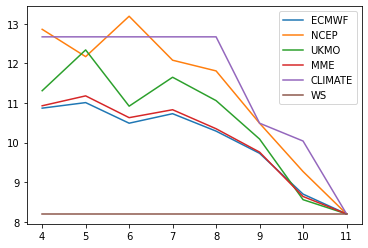

In [352]:
results.transpose().plot()